https://github.com/vivek081166/raw-audio-deep-learning/blob/master/constants.py

import pickle
from glob import iglob
import numpy as np
import librosa
from shutil import rmtree
from constants import *
# from constants import DATA_AUDIO_DIR

DATA_AUDIO_DIR = '../test_train_data'
list_dir = os.listdir(DATA_AUDIO_DIR)
list_dir.sort()
print(TARGET_SR)
TARGET_SR = 8000


def mkdir_p(path):
    import errno
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise


# def del_folder(path):
#     try:
#         rmtree(path)
#     except:
#         pass


# del_folder(OUTPUT_DIR_TRAIN)
# del_folder(OUTPUT_DIR_TEST)
mkdir_p(OUTPUT_DIR_TRAIN)
mkdir_p(OUTPUT_DIR_TEST)

order = 0
class_ids = {list_dir[i]: i for i in range(len(list_dir))}


def extract_class_id(wav_filename):
#     print(class_ids.get(str(wav_filename[18:-6])))
    return class_ids.get(wav_filename[19:-6])


def read_audio_from_filename(filename, target_sr):
    audio, _ = librosa.load(filename, sr=target_sr, mono=True)
    audio = audio.reshape(-1, 1)
    return audio


def convert_data():
    DATA_AUDIO_DIR = '../test_train_data'
    list_dir = os.listdir(DATA_AUDIO_DIR)
    list_dir.sort()
#     TARGET_SR = 16000
#     print(list_dir)
#     AUDIO_LENGTH = 200000
    for i, wav_filename in enumerate(iglob(os.path.join(DATA_AUDIO_DIR, '**/**.wav'), recursive=True)):
#         print(i, wav_filename)
        class_id = extract_class_id(wav_filename)
        audio_buf = read_audio_from_filename(wav_filename, target_sr=TARGET_SR)
        # normalize mean 0, variance 1
        audio_buf = (audio_buf - np.mean(audio_buf)) / np.std(audio_buf)
        original_length = len(audio_buf)
        print(i, wav_filename, original_length, np.round(np.mean(audio_buf), 4), np.std(audio_buf))
        if original_length < AUDIO_LENGTH:
            audio_buf = np.concatenate((audio_buf, np.zeros(shape=(AUDIO_LENGTH - original_length, 1))))
            print('PAD New length =', len(audio_buf))
        elif original_length > AUDIO_LENGTH:
#             audio_buf = audio_buf[10000:AUDIO_LENGTH+10000]
            audio_buf = audio_buf[0:AUDIO_LENGTH]
            print('CUT New length =', len(audio_buf))

        output_folder = OUTPUT_DIR_TRAIN
#         print("wav_filename_end : ", wav_filename[-5:])
        if wav_filename[-5:] == '5.wav':
            output_folder = OUTPUT_DIR_TEST

        output_filename = os.path.join(output_folder, str(wav_filename[19:-4]).replace('/', '_') + '.pkl')
#         TARGET_SR = 16000
        out = {'class_id': class_id,
               'audio': audio_buf,
               'sr': TARGET_SR}
        print("-----------------")
        print(out)
        with open(output_filename, 'wb') as w:
            pickle.dump(out, w)


if __name__ == '__main__':
    convert_data()

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow import convert_to_tensor
import numpy as np
import pickle
import os
from glob import glob

AUDIO_LENGTH = 10000
OUTPUT_DIR = './output'
OUTPUT_DIR_TRAIN = os.path.join(OUTPUT_DIR, 'train')
OUTPUT_DIR_TEST = os.path.join(OUTPUT_DIR, 'test')

DATA_AUDIO_DIR = '../test_train_data'
list_dir = os.listdir(DATA_AUDIO_DIR)
list_dir.sort()
# TARGET_SR = 16000

class_ids = {list_dir[i]: i for i in range(len(list_dir))}
def m5(num_classes):
    print("!!!!!!!!", num_classes)
    print('Using Model M5')
    m = Sequential()
    m.add(Conv1D(128,
                 input_shape=[AUDIO_LENGTH, 1],
                 kernel_size=80,
                 strides=4,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Conv1D(128,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Conv1D(256,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Conv1D(512,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
    m.add(Dense(num_classes, activation='softmax'))
    return m


def get_data(file_list):
    def load_into(_filename, _x, _y):
#         print("**** : ", _filename)
#         print("~`~` : ", _filename[15:-6])
        
        with open(_filename, 'rb') as f:
            audio_element = pickle.load(f)
            _x.append(audio_element['audio'])
            _y.append(int(audio_element['class_id']))

    x, y = [], []
    for filename in file_list:
#         print("Predict file name : ", filename)
        load_into(filename, x, y)
    return np.array(x), np.array(y)
#     return x, y




num_classes = len(list_dir)
print(num_classes)
model = m5(num_classes=len(list_dir))

if model is None:
    exit('Something went wrong!!')

model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
print(model.summary())

train_files = glob(os.path.join(OUTPUT_DIR_TRAIN, '**.pkl'))
x_tr, y_tr = get_data(train_files)
# print(len(x_tr))
# print(y_tr)
y_tr = to_categorical(y_tr, num_classes=num_classes)

test_files = glob(os.path.join(OUTPUT_DIR_TEST, '**.pkl'))
x_te, y_te = get_data(test_files)
y_tee = y_te
y_te = to_categorical(y_te, num_classes=num_classes)


print('x_tr.shape =', x_tr.shape)
print('y_tr.shape =', y_tr.shape)
print('x_te.shape =', x_te.shape)
print('y_te.shape =', y_te.shape)
print(type(x_te))

# if the accuracy does not increase over 10 epochs, reduce the learning rate by half.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)
batch_size = 128
history = model.fit(x=x_tr, y=y_tr, batch_size=16, epochs=200, verbose=2, shuffle=True, validation_data=(x_te, y_te), callbacks=[reduce_lr])
    
# epoch 500 audio_length 10000 min_lr 0.0001 sr 8000 batch_size 16 : val_acc 0.73
# epoch 500 audio_length 10000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.77(0.83)
# epoch 50 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.90
# epoch 100 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.93
# epoch 100 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 32 : val_acc 0.89(0.90) predict 0.75
# epoch 150 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.91 predict 0.75

115
!!!!!!!! 115
Using Model M5
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 2500, 128)         10368     
_________________________________________________________________
batch_normalization_12 (Batc (None, 2500, 128)         512       
_________________________________________________________________
activation_12 (Activation)   (None, 2500, 128)         0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 625, 128)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 625, 128)          49280     
_________________________________________________________________
batch_normalization_13 (Batc (None, 625, 128)          512       
_________________________________________________________________
activation_13 (Activat

Epoch 52/200
460/460 - 0s - loss: 0.3608 - accuracy: 0.9348 - val_loss: 1.8508 - val_accuracy: 0.5913
Epoch 53/200
460/460 - 1s - loss: 0.3540 - accuracy: 0.9370 - val_loss: 1.7592 - val_accuracy: 0.6174
Epoch 54/200
460/460 - 1s - loss: 0.3571 - accuracy: 0.9391 - val_loss: 1.7754 - val_accuracy: 0.6000
Epoch 55/200

Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
460/460 - 0s - loss: 0.3825 - accuracy: 0.9304 - val_loss: 1.6984 - val_accuracy: 0.6000
Epoch 56/200
460/460 - 0s - loss: 0.3288 - accuracy: 0.9391 - val_loss: 1.4866 - val_accuracy: 0.7043
Epoch 57/200
460/460 - 0s - loss: 0.3119 - accuracy: 0.9478 - val_loss: 1.4077 - val_accuracy: 0.7130
Epoch 58/200
460/460 - 0s - loss: 0.3068 - accuracy: 0.9522 - val_loss: 1.5874 - val_accuracy: 0.6783
Epoch 59/200
460/460 - 0s - loss: 0.3171 - accuracy: 0.9413 - val_loss: 1.4044 - val_accuracy: 0.6696
Epoch 60/200
460/460 - 0s - loss: 0.2960 - accuracy: 0.9609 - val_loss: 1.3532 - val_accuracy: 0.6870
E

460/460 - 0s - loss: 0.1895 - accuracy: 0.9804 - val_loss: 1.2198 - val_accuracy: 0.7565
Epoch 130/200
460/460 - 0s - loss: 0.2077 - accuracy: 0.9696 - val_loss: 1.1934 - val_accuracy: 0.7913
Epoch 131/200
460/460 - 0s - loss: 0.1907 - accuracy: 0.9696 - val_loss: 1.1835 - val_accuracy: 0.7739
Epoch 132/200
460/460 - 0s - loss: 0.1856 - accuracy: 0.9804 - val_loss: 1.1992 - val_accuracy: 0.7478
Epoch 133/200
460/460 - 0s - loss: 0.2053 - accuracy: 0.9739 - val_loss: 1.2000 - val_accuracy: 0.7652
Epoch 134/200
460/460 - 0s - loss: 0.1928 - accuracy: 0.9783 - val_loss: 1.2144 - val_accuracy: 0.7826
Epoch 135/200
460/460 - 0s - loss: 0.1861 - accuracy: 0.9826 - val_loss: 1.2354 - val_accuracy: 0.7565
Epoch 136/200
460/460 - 0s - loss: 0.1857 - accuracy: 0.9717 - val_loss: 1.2169 - val_accuracy: 0.7826
Epoch 137/200
460/460 - 0s - loss: 0.1887 - accuracy: 0.9717 - val_loss: 1.2019 - val_accuracy: 0.7565
Epoch 138/200
460/460 - 0s - loss: 0.1998 - accuracy: 0.9761 - val_loss: 1.2090 - val_a

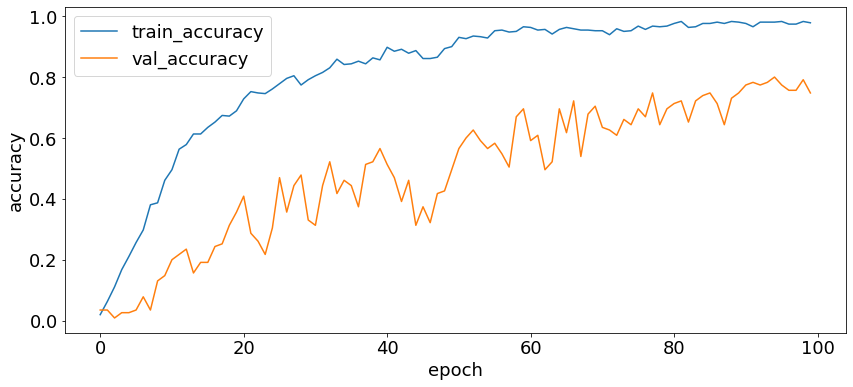

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.rc('font', size=18)

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

In [5]:
import pickle
from glob import iglob
import numpy as np
import librosa
from shutil import rmtree
from constants import *
from constants import DATA_AUDIO_DIR
DATA_AUDIO_VAL_DIR = '../test_val_data'
OUTPUT_DIR_VAL_TRAIN = './output_val/train'
OUTPUT_DIR_VAL_TEST = './output_val/test'

DATA_AUDIO_DIR = '../test_train_data'
list_dir = os.listdir(DATA_AUDIO_DIR)
list_dir.sort()

def mkdir_p(path):
    import errno
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise


# def del_folder(path):
#     try:
#         rmtree(path)
#     except:
#         pass


# del_folder(OUTPUT_DIR_TRAIN)
# del_folder(OUTPUT_DIR_TEST)
mkdir_p(OUTPUT_DIR_TRAIN)
mkdir_p(OUTPUT_DIR_TEST)

class_id = {list_dir[i]: i for i in range(len(list_dir))}


def extract_class_id(wav_filename):
    return class_ids.get(wav_filename[17:-6])


def read_audio_from_filename(filename, target_sr):
    audio, _ = librosa.load(filename, sr=target_sr, mono=True)
    audio = audio.reshape(-1, 1)
    return audio


def convert_data():
    DATA_AUDIO_DIR = '../test_train_data'
    list_dir = os.listdir(DATA_AUDIO_VAL_DIR)
    list_dir.sort()
    TARGET_SR = 8000
    print(list_dir)
#     AUDIO_LENGTH = 200000
#     TARGET_SR = 16000
    for i, wav_filename in enumerate(iglob(os.path.join(DATA_AUDIO_VAL_DIR, '**/**.wav'), recursive=True)):
        print(i, wav_filename)
        class_id = extract_class_id(wav_filename)
        audio_buf = read_audio_from_filename(wav_filename, target_sr=TARGET_SR)
        # normalize mean 0, variance 1
        audio_buf = (audio_buf - np.mean(audio_buf)) / np.std(audio_buf)
        original_length = len(audio_buf)
        print(i, wav_filename, original_length, np.round(np.mean(audio_buf), 4), np.std(audio_buf))
        if original_length < AUDIO_LENGTH:
            audio_buf = np.concatenate((audio_buf, np.zeros(shape=(AUDIO_LENGTH - original_length, 1))))
            print('PAD New length =', len(audio_buf))
        elif original_length > AUDIO_LENGTH:
            audio_buf = audio_buf[0:AUDIO_LENGTH]
#             audio_buf = audio_buf[10000:AUDIO_LENGTH+10000]
            print('CUT New length =', len(audio_buf))

        output_folder = OUTPUT_DIR_VAL_TRAIN
#         if i % 5 == 0:
#             output_folder = OUTPUT_DIR_VAL_TEST

        output_filename = os.path.join(output_folder, str(wav_filename[17:-4]).replace('/', '_') + '.pkl')

        out = {'class_id': class_id,
               'audio': audio_buf,
               'sr': TARGET_SR}
        print("-----------------")
        print(out)
        with open(output_filename, 'wb') as w:
            pickle.dump(out, w)


if __name__ == '__main__':
    convert_data()

['2017019740001_kwakjuheon', '2017019740029_limdonggeun', '2017019770001_kwonyuna', '2017019880001_kimsubin']
0 ../test_val_data/2017019880001_kimsubin/5.wav
0 ../test_val_data/2017019880001_kimsubin/5.wav 176844 -0.0 1.0
CUT New length = 10000
-----------------
{'class_id': 71, 'audio': array([[ 4.8197612e-06],
       [ 4.8197612e-06],
       [ 4.8197612e-06],
       ...,
       [-4.0558866e-01],
       [-2.9563633e-01],
       [-2.2197224e-01]], dtype=float32), 'sr': 8000}
1 ../test_val_data/2017019880001_kimsubin/4.wav
1 ../test_val_data/2017019880001_kimsubin/4.wav 175915 -0.0 1.0
CUT New length = 10000
-----------------
{'class_id': 71, 'audio': array([[-9.4105644e-06],
       [-9.4105644e-06],
       [-9.4105644e-06],
       ...,
       [-7.4374503e-01],
       [-6.9286388e-01],
       [-4.0462705e-01]], dtype=float32), 'sr': 8000}
2 ../test_val_data/2017019880001_kimsubin/6.wav
2 ../test_val_data/2017019880001_kimsubin/6.wav 179247 0.0 1.0
CUT New length = 10000
----------------

In [19]:
from sklearn.metrics import accuracy_score


x_tr_1, y_tr_1 = get_data(train_files_1)
# print('x_tr_1 : ', x_tr_1)
print('y_tr_1 : ', y_tr_1)

y_tr_12 = to_categorical(y_tr_1, num_classes=num_classes)
# print('y_tr_1 : ', y_tr_1)

pred_out = model.predict(x_tr_1)
# print('pred out : ', pred_out)

real =[]
pred_out_idex=[]

val_class_names = os.listdir(DATA_AUDIO_VAL_DIR)
print(val_class_names)
# val_class_names.sort()

DATA_AUDIO_DIR = '../test_train_data'
list_dir = os.listdir(DATA_AUDIO_DIR)
list_dir.sort()

j = 0
for i,pred in zip(range(0, len(pred_out)), pred_out) :
#     print('i : ', i)
#     print('pred : ', pred)
    print("pre : ", np.argmax(pred))
    if i == 5:
        j += 1
    print("Predict :",list_dir[np.argmax(pred)], ", Real :", list_dir[y_tr_1[i]])
    real.append(list_dir.index(list_dir[y_tr_1[i]]))
    pred_out_idex.append(np.argmax(pred))
    
# get the accuracy
print (accuracy_score(real, pred_out_idex))

y_tr_1 :  [ 0  0  0  0  0  0 28 31 31 31 31 31 31 71 71 71 71 71 71]
['2017019880001_kimsubin', '2017019740029_limdonggeun', '2017019770001_kwonyuna', '2017019740001_kwakjuheon']
pre :  0
Predict : 2017019740001_kwakjuheon , Real : 2017019740001_kwakjuheon
pre :  0
Predict : 2017019740001_kwakjuheon , Real : 2017019740001_kwakjuheon
pre :  12
Predict : 2017019740013_kwakyiheon , Real : 2017019740001_kwakjuheon
pre :  0
Predict : 2017019740001_kwakjuheon , Real : 2017019740001_kwakjuheon
pre :  26
Predict : 2017019740027_kwaksangpil , Real : 2017019740001_kwakjuheon
pre :  25
Predict : 2017019740026_parkyeongseon , Real : 2017019740001_kwakjuheon
pre :  28
Predict : 2017019740029_limdonggeun , Real : 2017019740029_limdonggeun
pre :  31
Predict : 2017019770001_kwonyuna , Real : 2017019770001_kwonyuna
pre :  31
Predict : 2017019770001_kwonyuna , Real : 2017019770001_kwonyuna
pre :  46
Predict : 2017019770016_parkjongae , Real : 2017019770001_kwonyuna
pre :  46
Predict : 2017019770016_park

In [20]:
# x_tr_1, y_tr_1 = get_data(train_files_1)
pred_out = model.predict(x_te)
# print('pred out : ', pred_out)

real =[]
pred_out_idex=[]


j = 0
for i,pred in zip(range(0, len(pred_out)), pred_out) :
#     print('i : ', i)
#     print('pred : ', pred)
    print("pre : ", np.argmax(pred), y_tee[i])
    print("Predict :",list_dir[np.argmax(pred)], ", Real :", list_dir[y_tee[i]])
    real.append(list_dir.index(list_dir[y_tee[i]]))
    pred_out_idex.append(np.argmax(pred))
    
# get the accuracy
print (accuracy_score(real, pred_out_idex))

pre :  66 39
Predict : 2017019770036_yuminji , Real : 2017019770009_yuminji
pre :  112 112
Predict : 2017019880042_namyeji , Real : 2017019880042_namyeji
pre :  110 110
Predict : 2017019880040_shinheewook , Real : 2017019880040_shinheewook
pre :  40 40
Predict : 2017019770010_parksojin , Real : 2017019770010_parksojin
pre :  88 88
Predict : 2017019880018_wonjoonho , Real : 2017019880018_wonjoonho
pre :  34 34
Predict : 2017019770004_leebyeongjin , Real : 2017019770004_leebyeongjin
pre :  43 43
Predict : 2017019770013_janghyomin , Real : 2017019770013_janghyomin
pre :  101 101
Predict : 2017019880031_ahnjiwoo , Real : 2017019880031_ahnjiwoo
pre :  71 71
Predict : 2017019880001_kimsubin , Real : 2017019880001_kimsubin
pre :  46 46
Predict : 2017019770016_parkjongae , Real : 2017019770016_parkjongae
pre :  55 55
Predict : 2017019770025_kimhyeonsu , Real : 2017019770025_kimhyeonsu
pre :  67 90
Predict : 2017019770037_jeonghojun , Real : 2017019880020_yoonhyeeun
pre :  15 15
Predict : 20170